In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random


seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
X = np.load('/content/drive/MyDrive/ugs_input_256/X.npy')
y = np.load('/content/drive/MyDrive/ugs_input_256/y.npy')
print(X.shape, y.shape)

(1500, 256, 256, 3) (1500, 256, 256, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(1350, 256, 256, 3) (1350, 256, 256, 1) (150, 256, 256, 3) (150, 256, 256, 1)


22

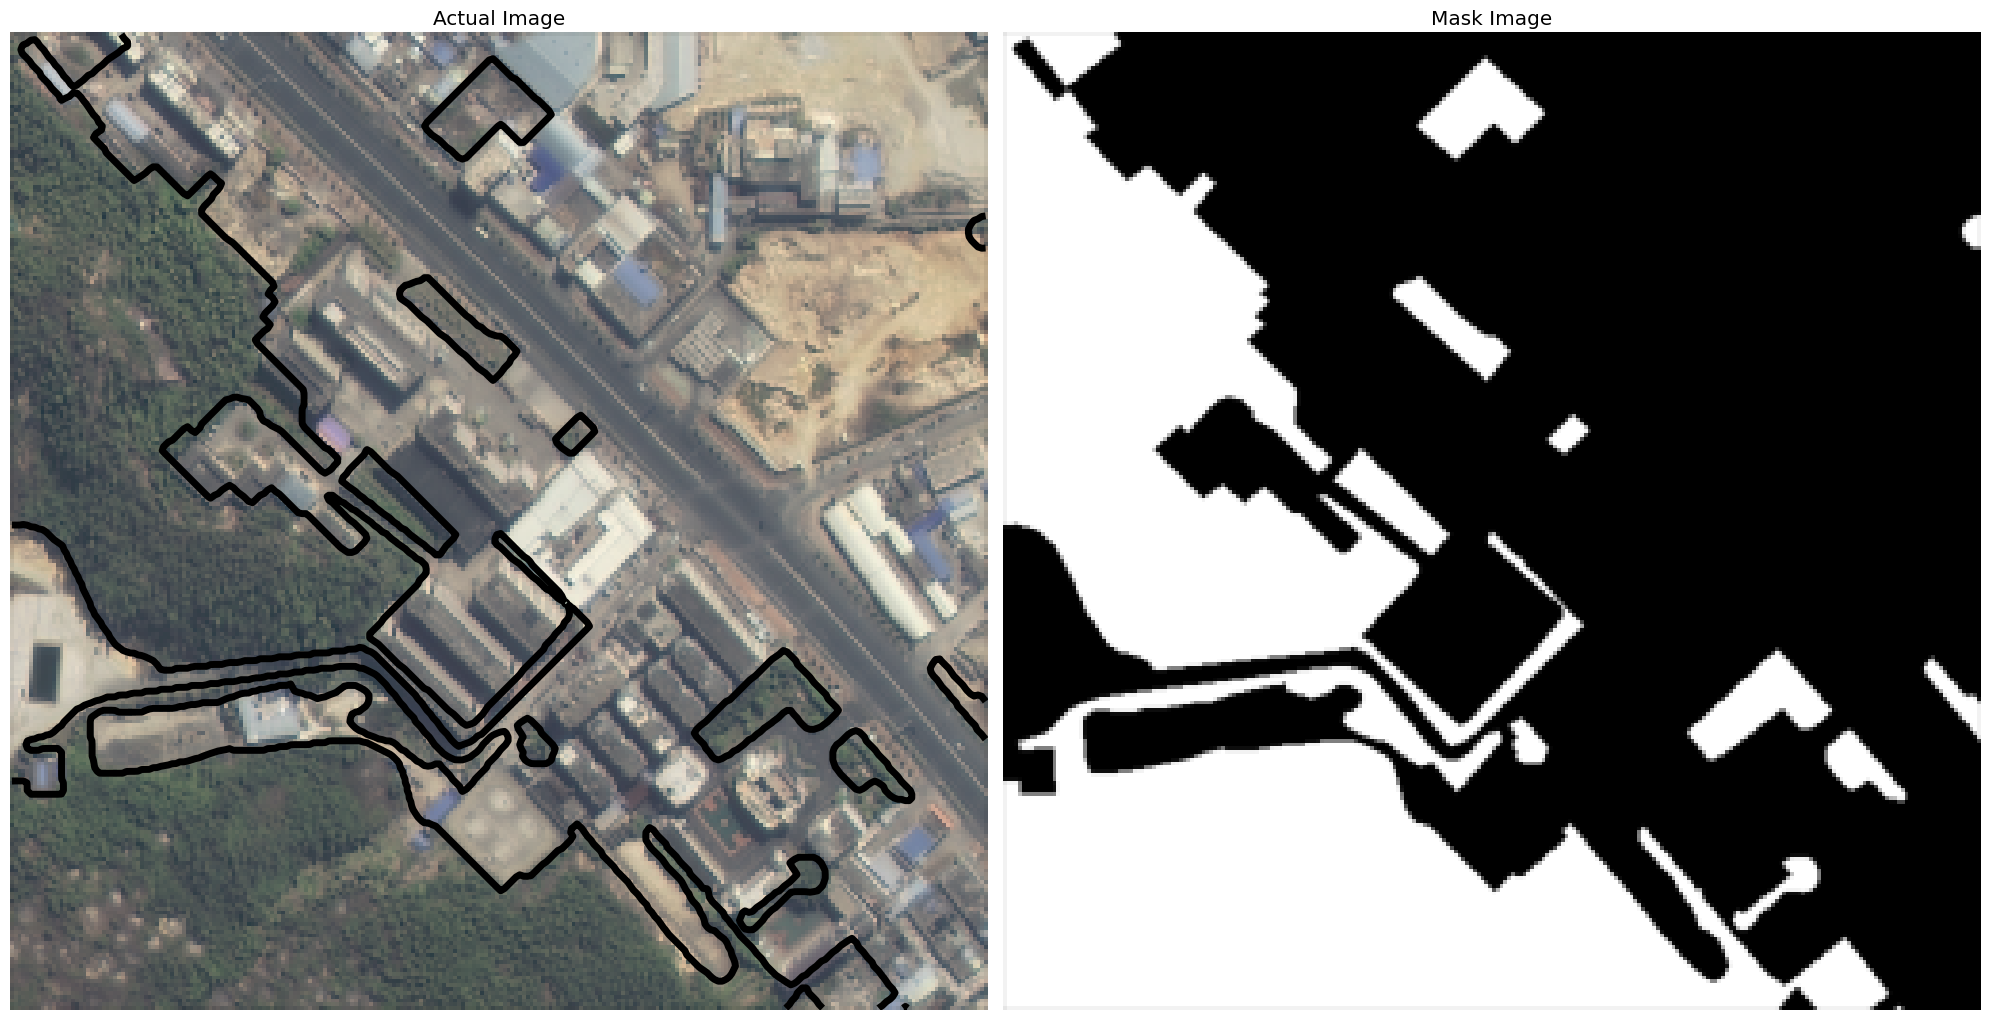

In [ ]:
import matplotlib.pyplot as plt

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))


if len(X_train.shape) == 3 and X_train.shape[2] == 3:
    ax1.imshow(X_train[ix])
else:
    ax1.imshow(X_train[ix], cmap='gray')

if has_mask:
    ax1.contour(y_train[ix].squeeze(), colors='k', linewidths=5, levels=[0.5])

ax1.set_title('Actual Image')
ax1.set_axis_off()

ax2.imshow(y_train[ix].squeeze(), cmap='gray')
ax2.set_title('Mask Image')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow as tf

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):


    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_resnet_unet(input_shape, n_filters=16, dropout=0.1, batchnorm=True):
    inputs = Input(input_shape, name='img_input')

   #Pretrained ResNet Model
    resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=input_shape)


    s1 = resnet.get_layer("img_input").output
    s2 = resnet.get_layer("conv1_relu").output    # 128x128
    s3 = resnet.get_layer("conv2_block3_out").output  # 64x64
    s4 = resnet.get_layer("conv3_block4_out").output  # 32x32
    s5 = resnet.get_layer("conv4_block6_out").output  # 16x16


    b1 = conv2d_block(s5, n_filters * 32, kernel_size=3, batchnorm=batchnorm)
    b1 = Dropout(dropout)(b1)


    d1 = Conv2DTranspose(n_filters * 16, (3, 3), strides=(2, 2), padding='same')(b1)
    d1 = concatenate([d1, s4])
    d1 = conv2d_block(d1, n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    d2 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(d1)
    d2 = concatenate([d2, s3])
    d2 = conv2d_block(d2, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    d3 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(d2)
    d3 = concatenate([d3, s2])
    d3 = conv2d_block(d3, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    d4 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(d3)
    d4 = concatenate([d4, s1])
    d4 = conv2d_block(d4, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model = build_resnet_unet(input_shape, n_filters=16, dropout=0.05, batchnorm=True)

# Metrics (Binary Cross Entropy)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['img_input[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ResNet-Unet_256.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]


results = model.fit(X_train, y_train, batch_size=8, epochs=40, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/40
169/169 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.7363 - auc: 0.8149
Epoch 1: val_loss improved from inf to 4.39232, saving model to model-ResNet-Unet_256.h5
169/169 [==============================] - 119s 387ms/step - loss: 0.4340 - accuracy: 0.7363 - auc: 0.8149 - val_loss: 4.3923 - val_accuracy: 0.6803 - val_auc: 0.4990 - lr: 0.0010
Epoch 2/40
169/169 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.7498 - auc: 0.8428
Epoch 2: val_loss improved from 4.39232 to 1.23929, saving model to model-ResNet-Unet_256.h5
169/169 [==============================] - 51s 303ms/step - loss: 0.4046 - accuracy: 0.7498 - auc: 0.8428 - val_loss: 1.2393 - val_accuracy: 0.6803 - val_auc: 0.4344 - lr: 0.0010
Epoch 3/40
169/169 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.7550 - auc: 0.8503
Epoch 3: val_loss improved from 1.23929 to 1.16448, saving model to model-ResNet-Unet_256.h5
169/169 [===========================

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,val_loss,val_accuracy,val_auc,lr
13,0.292892,0.806293,0.919510,0.333123,0.781567,0.895466,0.00010
15,0.277461,0.813388,0.928143,0.334726,0.781454,0.896258,0.00010
16,0.272174,0.815754,0.930627,0.335290,0.780641,0.896822,0.00010
17,0.266365,0.817999,0.933692,0.336750,0.780661,0.894724,0.00010
14,0.283819,0.810682,0.924580,0.338226,0.779439,0.894699,0.00010
19,0.258142,0.821804,0.938188,0.341614,0.778961,0.894046,0.00001
22,0.259157,0.821617,0.937500,0.341617,0.779600,0.894872,0.00001
21,0.256496,0.822310,0.938909,0.342293,0.779318,0.894262,0.00001
20,0.258386,0.821999,0.938328,0.342392,0.779077,0.893884,0.00001
23,0.256751,0.822512,0.938671,0.342598,0.779242,0.894210,0.00001


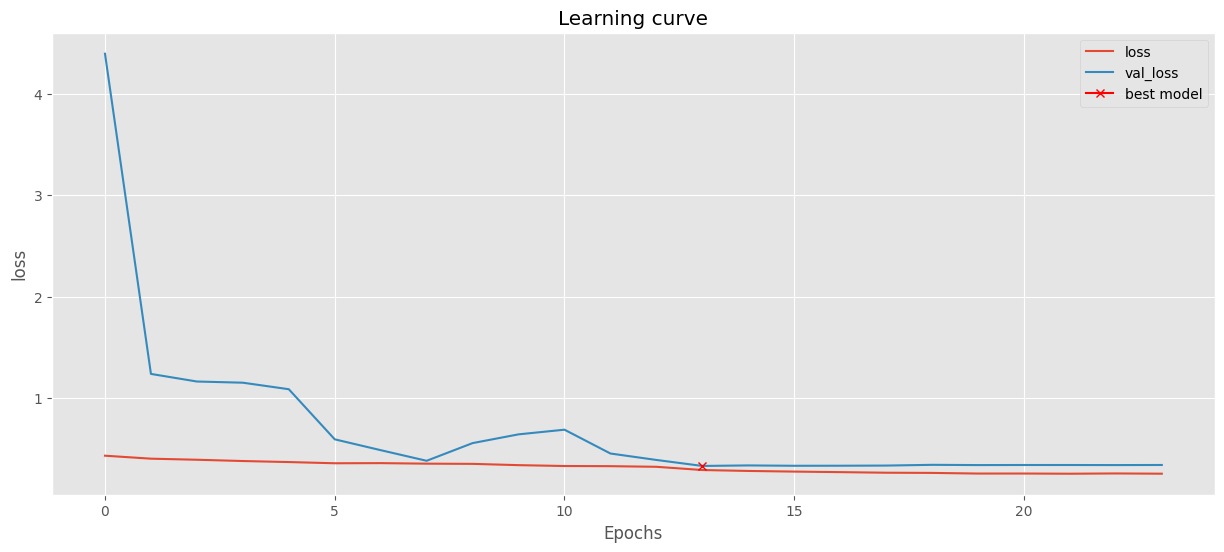

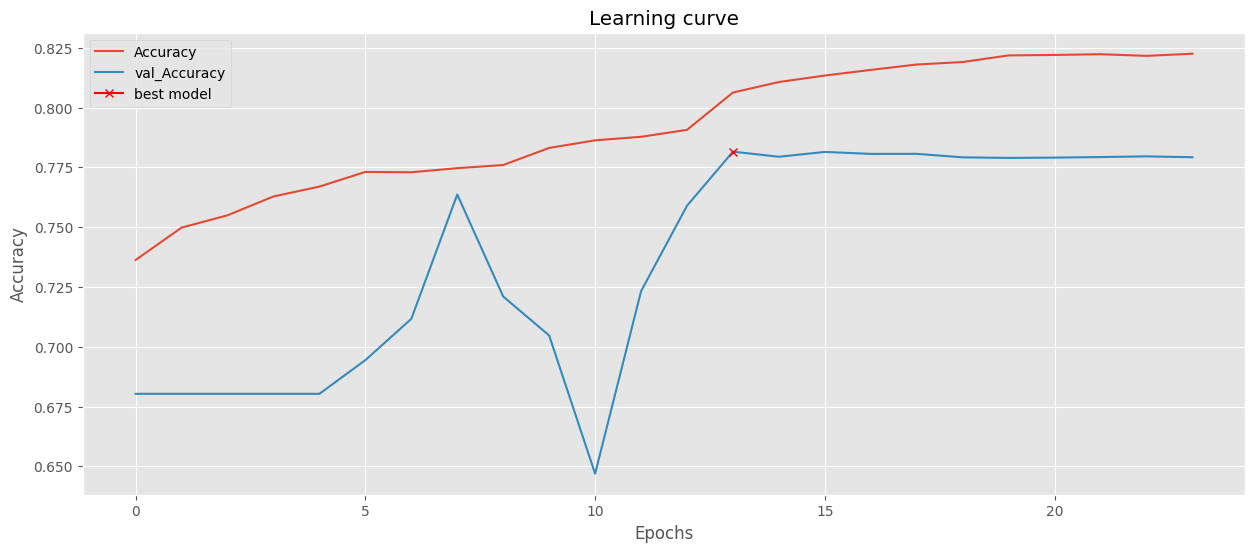

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
model.load_weights('/content/drive/MyDrive/model-ResNet-Unet_256.h5')

In [ ]:
model.evaluate(X_test[:], y_test[:], verbose=1)

5/5 [==============================] - 117s 23s/step - loss: 0.3461 - accuracy: 0.7786 - auc: 0.8931


[0.34613099694252014, 0.7786422967910767, 0.8930818438529968]

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

5/5 [==============================] - 106s 21s/step


In [ ]:
preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.4).astype(np.uint8)

In [ ]:
def get_dice(mask1, mask2):
    mask1 = mask1.flatten()
    mask2 = mask2.flatten()
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)
    return dice

Dice Coefficient:  0.893


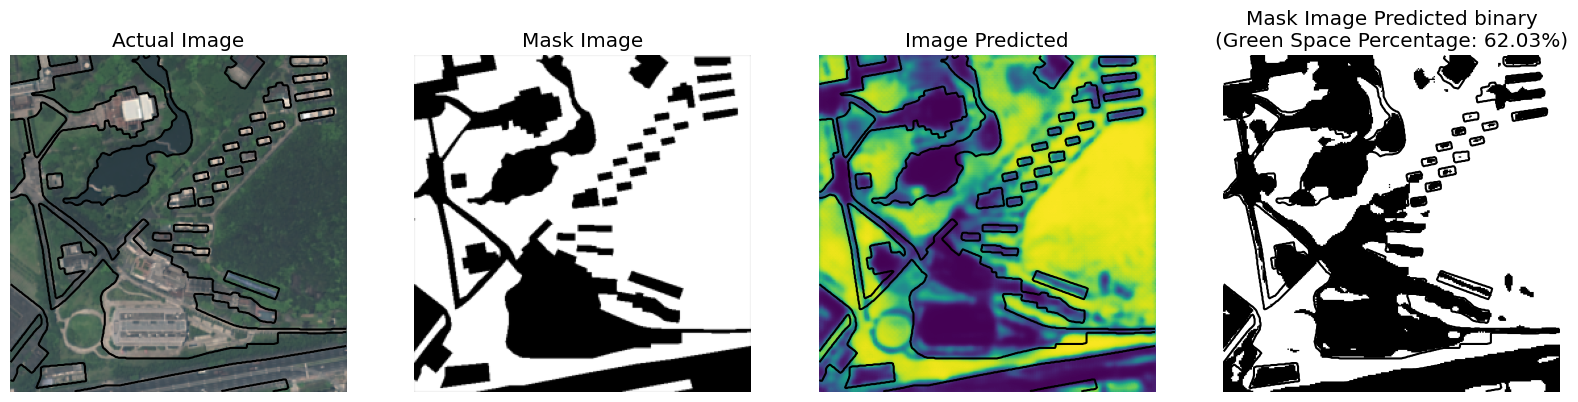

In [ ]:
def plot_sample_with_pixel_percentage(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0


    white_pixels_in_label = np.count_nonzero(y[ix])
    total_pixels_in_label = y[ix].size
    white_pixel_percentage_label = (white_pixels_in_label / total_pixels_in_label) * 100


    white_pixels_in_predicted = np.count_nonzero(binary_preds[ix])
    total_pixels_in_predicted = binary_preds[ix].size
    white_pixel_percentage_predicted = (white_pixels_in_predicted / total_pixels_in_predicted) * 100


    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Actual Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), cmap='viridis', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title("Image Predicted")
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title(f'Mask Image Predicted binary\n(Green Space Percentage: {white_pixel_percentage_predicted:.2f}%)')
    ax[3].set_axis_off()
    print("Dice Coefficient: " , get_dice(y[ix].squeeze(),binary_preds[ix].squeeze()))



plot_sample_with_pixel_percentage(X_test, y_test, preds_val, preds_val_t)
